# Training Embeddings

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import json

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from nltk.tokenize import RegexpTokenizer
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


import os

import time

from gensim.models import Word2Vec
from tqdm import tqdm

tqdm.pandas()

warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# load the data 
with open('phys_all.txt', 'r') as infile:
    data_dic = json.load(infile)
infile.close()

In [3]:
def preprocessing(abstracts):
    
    processed_array = []
    
    for abstract in tqdm(abstracts):
        #print(abstract)
        # remove other non-alphabets symbols with space (i.e. keep only alphabets and whitespaces).
        processed = re.sub('\n', ' ', abstract)
        words = re.sub('[^a-zA-Z ]', '', processed).split()
        
        
        # keep words that have length of more than 1 (e.g. gb, bb), remove those with length 1.
        processed_array.append(' '.join([word.lower() for word in words if len(word) > 1]))
    
    return processed_array

In [4]:
abstracts = []
for key in data_dic.keys(): 
    abstracts.append(data_dic[key]["abstract"])#.keys()

In [5]:
corp_all = []
for abstr in abstracts: 
    corp_all.append(gensim.utils.simple_preprocess(abstr))

## Embeddings for different years

In [8]:
# load the data
with open('docs_lemm_clean_phys_1995.txt', 'r') as infile:
    abstracts_1995 = json.load(infile)
infile.close()

In [9]:
with open('docs_lemm_clean_phys_2005.txt', 'r') as infile:
    abstracts_2005 = json.load(infile)
infile.close()

In [10]:
with open('docs_lemm_clean_phys_2015.txt', 'r') as infile:
    abstracts_2015 = json.load(infile)
infile.close()

In [11]:
with open('docs_lemm_clean_all_phys.txt', 'r') as infile:
    abstracts_all = json.load(infile)
infile.close()

In [12]:
len(abstracts_1995), len(abstracts_2005), len(abstracts_2015), len(abstracts_all)#(24666, 61505, 106701, 50000)

(24666, 61505, 106701, 50000)

## Train Word2Vec

In [13]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

#### Model for 1995

In [14]:
workers = cores-1
vector_size = 100
model = 1 # 1 for skip-gram; otherwise CBOW
min_count = 20
n_epochs = 10
negative_sampl =  10 # – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
hs_neg_sampl = 0 # to use negative sampling 


In [10]:
# model for 1995
start_time = time.time()

sentences_1995=abstracts_1995 

model_sg_1995 = Word2Vec(sg=model,  # 1 for skip-gram; otherwise CBOW
                         size=vector_size, 
                         workers=workers, 
                         min_count = min_count, 
                         negative = negative_sampl, 
                         hs = hs_neg_sampl)

In [11]:
# initialising the vocabulary tabel
t = time.time()
model_sg_1995.build_vocab(sentences_1995, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.02 mins


In [12]:
# train model
t = time.time()
model_sg_1995.train(sentences_1995, total_examples=model_sg_1995.corpus_count, epochs=n_epochs, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2))) # ca. 30 seconds

Time to train the model: 0.62 mins


#### Model for 2005

In [13]:
# model for 2005
start_time = time.time()
sentences_2005 =abstracts_2005
model_sg_2005 = Word2Vec(sg=model,  # 1 for skip-gram; otherwise CBOW
                 size=vector_size,
                 workers=workers, 
                 min_count = min_count, 
                 negative = negative_sampl, 
                 hs = hs_neg_sampl)

# initialising the vocabulary tabel
t = time.time()
model_sg_2005.build_vocab(sentences_2005, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.05 mins


In [14]:
# train model
t = time.time()
model_sg_2005.train(sentences_2005, total_examples=model_sg_2005.corpus_count, epochs=n_epochs, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2))) # ca. 1 min

Time to train the model: 1.64 mins


#### Model for 2015

In [15]:
# model for 2015
start_time = time.time()

sentences_2015=abstracts_2015 

model_sg_2015 = Word2Vec(sg=model, # 1 for skip-gram; otherwise CBOW
                         size=vector_size,
                         workers=workers, 
                         min_count = min_count, 
                         negative = negative_sampl, 
                         hs = hs_neg_sampl)

# initialising the vocabulary tabel
t = time.time()
model_sg_2015.build_vocab(sentences_2015, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))


# train model
t = time.time()
model_sg_2015.train(sentences_2015, total_examples=model_sg_2015.corpus_count, epochs=n_epochs, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.1 mins
Time to train the model: 3.86 mins


In [17]:
print("2005-1995")
print(np.linalg.norm((model_sg_2005.wv['radiation'] - model_sg_1995.wv['radiation'])))
print("\n2015-2005")
print(np.linalg.norm((model_sg_2015.wv['radiation'] - model_sg_2005.wv['radiation'])))
print("\n2015-1995")
print(np.linalg.norm((model_sg_2015.wv['radiation'] - model_sg_1995.wv['radiation'])))

2005-1995
3.4732172

2015-2005
3.4377112

2015-1995
3.8171022


!!!!These embeddings are not alinged hence you cannot interpret them!!!!

## Model with bigrams & traigrams

In [ ]:
# load the data
with open('phys_dic.txt', 'r') as infile:
    phys_dic = json.load(infile)
infile.close()

To do the Procrustes matrix alignement, I utilised code adapted from https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf, which can be found below. 

This Code is ported from the HistWords project <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.

In [33]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords>
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    base_embed.init_sims()
    other_embed.init_sims()

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = in_base_embed.wv.syn0norm
    other_vecs = in_other_embed.wv.syn0norm

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    
    # another matrix operation
    ortho = u.dot(v) 
    
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (other_embed.wv.syn0norm).dot(ortho)
    
    return other_embed

In [32]:
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.If 
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = m.wv.syn0norm
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.wv.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [ ]:
# First one is the base model and the second model will be alinged to it
# these models are alinged to 2015

aligned_model_sg_1995 = smart_procrustes_align_gensim(model_sg_2015, model_sg_1995)
aligned_model_sg_2005 = smart_procrustes_align_gensim(model_sg_2015, model_sg_2005)

In [21]:
print("2005-1995")
print(np.linalg.norm((aligned_model_sg_2005.wv['radiation'] - aligned_model_sg_1995.wv['radiation'])))
print("\n2015-2005")
print(np.linalg.norm((model_sg_2015.wv['radiation'] - aligned_model_sg_2005.wv['radiation'])))
print("\n2015-1995")
print(np.linalg.norm((model_sg_2015.wv['radiation'] - aligned_model_sg_1995.wv['radiation'])))

2005-1995
0.7113548

2015-2005
0.56644607

2015-1995
0.73626465


In [22]:
# save embeddings
aligned_model_sg_1995.save("model_sg_1995_embedding_alinged_to_2015_sk_neg_sampl")
aligned_model_sg_2005.save("model_sg_2005_embedding_alinged_to_2015_sk_neg_sampl")

model_sg_2015.save("model_sg_2015_embedding_sk_neg_sampl")

In [23]:
aligned_model_sg_2015 = smart_procrustes_align_gensim(model_sg_2015, model_sg_2015)

np.linalg.norm((aligned_model_sg_1995.wv['radiation'] - model_sg_1995.wv['radiation']))

0.0

#### Investigation of the embedding

In [31]:
print("Radiation 1995:")
pprint(model_sg_1995.most_similar('radiation', topn = 20))
print("Radiation 2015:")
pprint(model_sg_2015.most_similar('radiation', topn = 20))

Radiation 1995:
[('emitted', 0.6535622477531433),
 ('backreaction', 0.6384514570236206),
 ('infalling', 0.6360871195793152),
 ('doppler', 0.6321619749069214),
 ('bremsstrahlung', 0.6294287443161011),
 ('emission', 0.621976375579834),
 ('unruh', 0.6117062568664551),
 ('evaporating', 0.6077607870101929),
 ('hawking', 0.5952773094177246),
 ('collisional', 0.5952439308166504),
 ('thermal', 0.5807656049728394),
 ('reservoir', 0.578682541847229),
 ('bath', 0.5741452574729919),
 ('radiated', 0.5741233825683594),
 ('divertor', 0.5717113018035889),
 ('plasma', 0.5690270066261292),
 ('gravitational', 0.5658248662948608),
 ('outgoing', 0.5640892386436462),
 ('back', 0.5612143278121948),
 ('loss', 0.5608574748039246)]
Radiation 2015:
[('emitted', 0.6450365781784058),
 ('emission', 0.6384903192520142),
 ('hawking', 0.6290760040283203),
 ('bremsstrahlung', 0.6275709867477417),
 ('electromagnetic', 0.6250782012939453),
 ('thermal', 0.6221785545349121),
 ('radiated', 0.6187897324562073),
 ('absorbed',

In [32]:
print("energy 1995:")
pprint(model_sg_1995.most_similar('energy', topn=20))
print("energy 2015:")
pprint(model_sg_2015.most_similar('energy', topn=20))

energy 1995:
[('moderately', 0.6195979118347168),
 ('radiated', 0.5888413190841675),
 ('temperature', 0.5827327966690063),
 ('low', 0.575496256351471),
 ('high', 0.5634934306144714),
 ('momentum', 0.5496737957000732),
 ('height', 0.5492907762527466),
 ('lab', 0.5429461598396301),
 ('antiproton', 0.5328117609024048),
 ('pressure', 0.5323392152786255),
 ('bombarding', 0.5279592275619507),
 ('triton', 0.5209634304046631),
 ('stopping', 0.5201259851455688),
 ('nonperturbatively', 0.5161985158920288),
 ('resulting', 0.5138179659843445),
 ('moderate', 0.5131667256355286),
 ('softer', 0.5083327293395996),
 ('incident', 0.5079765319824219),
 ('viscous', 0.5073935985565186),
 ('lam', 0.5041695237159729)]
energy 2015:
[('momentum', 0.6276414394378662),
 ('proton', 0.5755234956741333),
 ('total', 0.5595611929893494),
 ('corresponding', 0.5505108833312988),
 ('electron', 0.5504783391952515),
 ('slope', 0.5460430383682251),
 ('energetic', 0.5367594957351685),
 ('mass', 0.5356589555740356),
 ('conse

In [33]:
print("gravity 1995:")
pprint(model_sg_1995.most_similar('gravity'))
print("gravity 2015:")
pprint(model_sg_2015.most_similar('gravity'))

gravity 1995:
[('2d', 0.6388871669769287),
 ('teitelboim', 0.6197099685668945),
 ('4d', 0.5794891119003296),
 ('field', 0.5750183463096619),
 ('relativity', 0.5636317729949951),
 ('dilaton', 0.5579084157943726),
 ('electrodynamics', 0.5556502342224121),
 ('electromagnetism', 0.5543911457061768),
 ('liouville', 0.5542653203010559),
 ('minisuperspace', 0.5524683594703674)]
gravity 2015:
[('gravitation', 0.7463563680648804),
 ('relativity', 0.7139763236045837),
 ('cosmology', 0.7091866731643677),
 ('bran', 0.7041919827461243),
 ('bonnet', 0.6876737475395203),
 ('gravitational', 0.6706119775772095),
 ('cosmological', 0.6580513119697571),
 ('einstein', 0.6514589786529541),
 ('spacetime', 0.6495286822319031),
 ('torsion', 0.6337090730667114)]


In [34]:
print("environment 1995:")
pprint(model_sg_1995.most_similar('environment', topn=20))
print("environment 2015:")
pprint(model_sg_2015.most_similar('environment', topn=20))

environment 1995:
[('reservoir', 0.6931085586547852),
 ('decoherence', 0.6538130044937134),
 ('apparatus', 0.6245404481887817),
 ('decoherent', 0.6045819520950317),
 ('bath', 0.5836710929870605),
 ('device', 0.5804972648620605),
 ('ionization', 0.5789768695831299),
 ('dissipative', 0.5727277994155884),
 ('subsystem', 0.5623634457588196),
 ('operational', 0.560486376285553),
 ('qubit', 0.5567657947540283),
 ('memory', 0.5491942763328552),
 ('dissipation', 0.5478906631469727),
 ('efficiently', 0.544344961643219),
 ('mechanical', 0.5390843152999878),
 ('noise', 0.5381966829299927),
 ('mesoscopic', 0.5326758027076721),
 ('computer', 0.5322532653808594),
 ('partons', 0.531853973865509),
 ('disentangle', 0.5307022333145142)]
environment 2015:
[('reservoir', 0.7216598987579346),
 ('bath', 0.6879507303237915),
 ('system', 0.6646468639373779),
 ('surrounding', 0.6180537939071655),
 ('noisy', 0.581332266330719),
 ('dynamic', 0.5692967176437378),
 ('markovian', 0.5682664513587952),
 ('subsystem',

In [35]:
print("change 1995:")
pprint(model_sg_1995.most_similar('change'))
print("change 2015:")
pprint(model_sg_2015.most_similar('change'))

change 1995:
[('affect', 0.6776361465454102),
 ('drastically', 0.6597111225128174),
 ('varied', 0.638910174369812),
 ('modification', 0.6174931526184082),
 ('tiny', 0.6091170310974121),
 ('changed', 0.6080078482627869),
 ('increase', 0.6050211787223816),
 ('dramatically', 0.6032954454421997),
 ('altered', 0.6032055616378784),
 ('modify', 0.5967552661895752)]
change 2015:
[('variation', 0.7582494020462036),
 ('changed', 0.7072524428367615),
 ('vary', 0.6987208127975464),
 ('affect', 0.6941711902618408),
 ('alter', 0.6804742217063904),
 ('varies', 0.6765041351318359),
 ('depend', 0.6757429242134094),
 ('depends', 0.6749731302261353),
 ('influence', 0.6700727939605713),
 ('affected', 0.6657277345657349)]


##### Create TSNE plot to investigate the embeddings 

In [36]:
from sklearn.manifold import TSNE

In [37]:
def plot_tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [38]:
model_sg_1995_select_1 = Word2Vec(sentences=abstracts_1995, 
                                  sg=1, 
                                  size=100,
                                  window=20, 
                                  min_count=2500,
                                  workers=8)

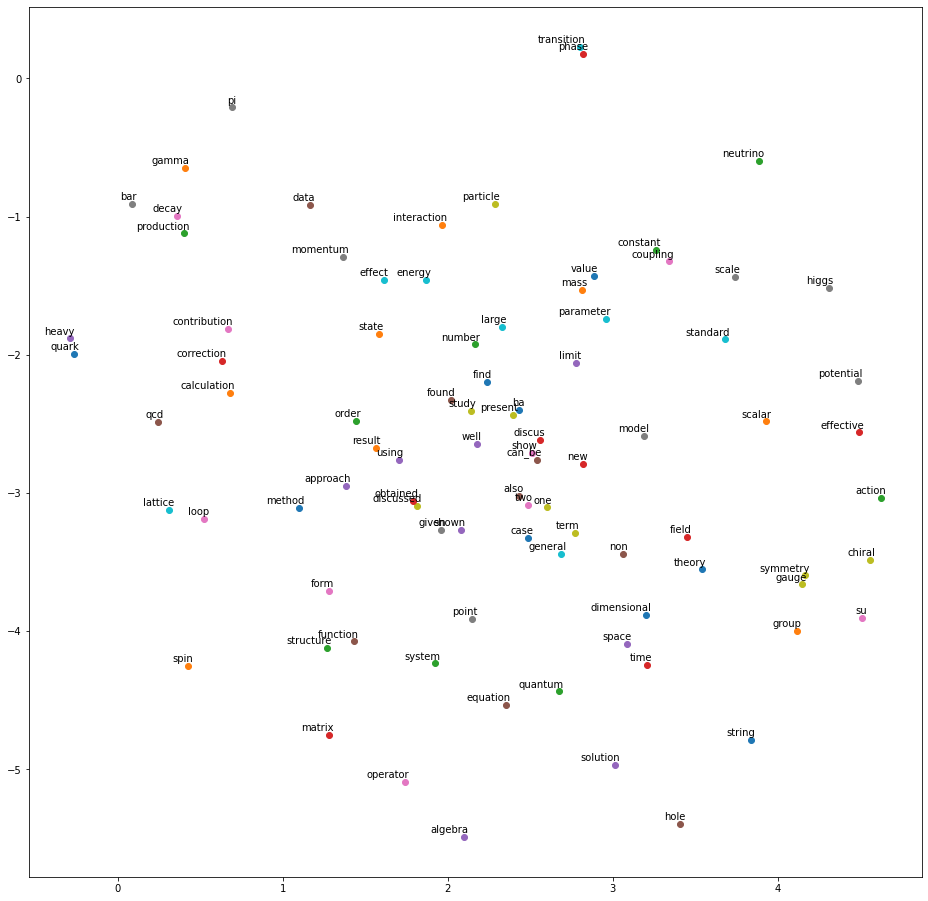

In [39]:
plot_tsne_plot(model_sg_1995_select_1)

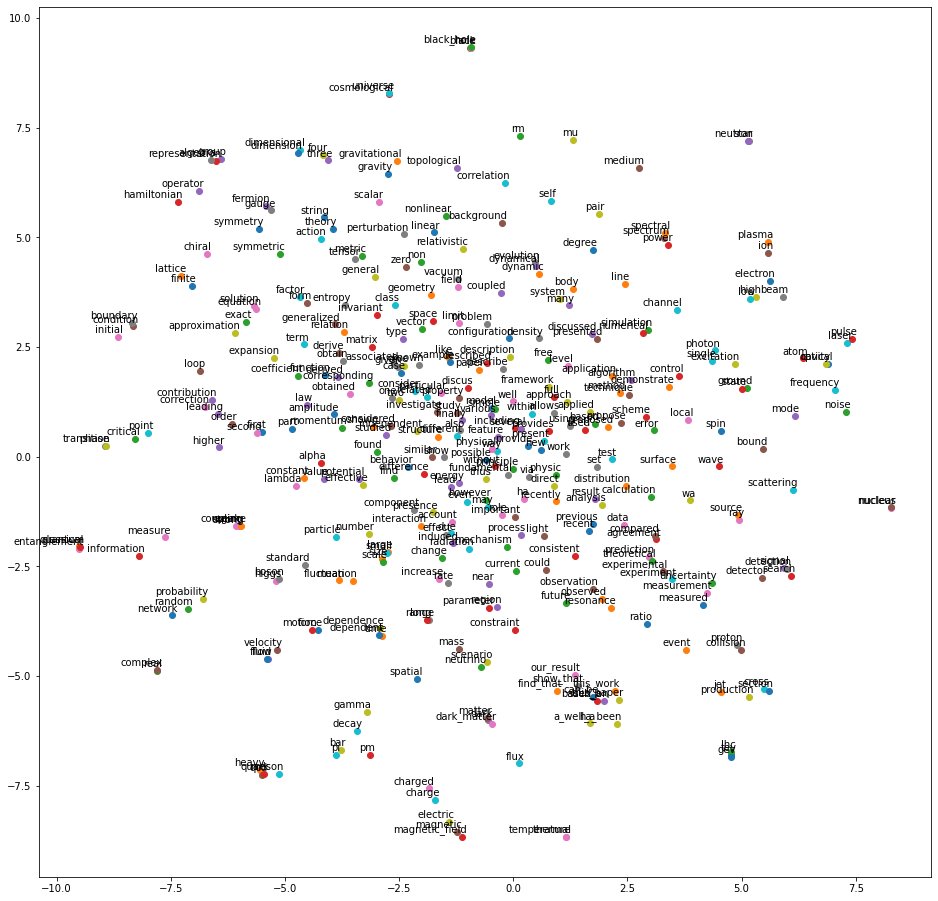

In [40]:
model_sg_2015_select_1 = Word2Vec(sentences=abstracts_2015, 
                                  sg=1, 
                                  size=100,
                                  window=20, 
                                  min_count=5000,
                                  workers=8)
plot_tsne_plot(model_sg_2015_select_1)

## Train FastText embeddings

In [23]:
workers = cores-1
vector_size = 100
model = 1 # 1 for skip-gram; otherwise CBOW
min_count = 10
n_epochs = 50
negative_sampl =  10 # – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
hs_neg_sampl = 0 # to use negative sampling 

In [24]:
sentences_1995=abstracts_1995
sentences_2005=abstracts_2005
sentences_2015=abstracts_2015 

len(sentences_1995), len(sentences_2005), len(sentences_2015) 

(24666, 61505, 106701)

#### Model in 1995

In [26]:
from gensim.models import FastText

FastText_model1995 = FastText(sg=model,  # 1 for skip-gram; otherwise CBOW
                              size=vector_size, 
                              workers=workers, 
                              min_count = min_count, 
                              negative = negative_sampl, 
                              hs = hs_neg_sampl)

FastText_model1995.build_vocab(sentences=sentences_1995)

# train model
t = time.time()
FastText_model1995.train(sentences=sentences_1995, total_examples=len(sentences_1995), epochs=n_epochs)  # train
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 6.17 mins


#### Model in 2005

In [27]:
FastText_model2005 = FastText(sg=model,  # 1 for skip-gram; otherwise CBOW
                              size=vector_size, 
                              workers=workers, 
                              min_count = min_count, 
                              negative = negative_sampl, 
                              hs = hs_neg_sampl)  

FastText_model2005.build_vocab(sentences=sentences_2005)

# train model
t = time.time()
FastText_model2005.train(sentences=sentences_2005, total_examples=len(sentences_2005), epochs=n_epochs)  
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 17.87 mins


#### Model for 2015

In [28]:
FastText_model2015 = FastText(sg=model,  # 1 for skip-gram; otherwise CBOW
                              size=vector_size, 
                              workers=workers, 
                              min_count = min_count, 
                              negative = negative_sampl, 
                              hs = hs_neg_sampl)

FastText_model2015.build_vocab(sentences=sentences_2015)

# train model
t = time.time()
FastText_model2015.train(sentences=sentences_2015, total_examples=len(sentences_2015), epochs=n_epochs)  
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 43.31 mins


#### Align FastText embeddings

In [34]:
aligned_FastText_model1995 = smart_procrustes_align_gensim(FastText_model2015, FastText_model1995)
aligned_FastText_model2005 = smart_procrustes_align_gensim(FastText_model2015, FastText_model2005)

#### Save the model

In [35]:
# Save model to disk.
aligned_FastText_model1995.save("model_FastText_1995_embedding_alinged_to_2015_2")

aligned_FastText_model2005.save("model_FastText_2005_embedding_alinged_to_2015_2")

FastText_model2015.save("model_FastText_embedding_2015_2")